## Addressing Issues in the Previous MLP-based Approach

* **Problem:**

  * The model’s initial loss was observed to be approximately **27.051**, which is abnormally high.
  * In a worst-case scenario, if the model outputs a uniform probability distribution over the vocabulary (i.e., each token has probability $\frac{1}{27}$), the expected cross-entropy loss should be:

  $$
  \mathcal{L} = -\log\left(\frac{1}{27}\right) \approx 3.2958
  $$

  * Hence, the observed loss is far greater than the theoretical baseline, indicating poor initialization of the output layer parameters.

* **Solution:**

  * To stabilize training and align the model’s initial behavior closer to a uniform distribution, the **logits** should be initialized near zero.
  * This can be achieved by carefully initializing the final layer’s **weights** and **biases** close to zero, ensuring that the model does not start with extremely skewed or saturated probabilities.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', mode = 'r', encoding='utf-8').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}

In [4]:
x, y = [], []
block_size = 3
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        idx = stoi[ch]
        x.append(context)
        y.append(idx)
        # print(f"{''.join([itos[i] for i in context])} --> {itos[idx]}")
        context = context[1:] + [idx]
x, y = torch.tensor(x), torch.tensor(y)

In [5]:
def generate_dataset(words):
    x, y = [], []
    block_size = 3
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            x.append(context)
            y.append(idx)
            # print(f"{''.join([itos[i] for i in context])} --> {itos[idx]}")
            context = context[1:] + [idx]
    x, y = torch.tensor(x), torch.tensor(y)
    return x, y

def get_split(data, train_split: float, test_split: float, val_split: float):
    import random
    random.seed(42)

    if (train_split + test_split + val_split) != 1:
        raise ValueError("All splits must sum to 100% of the data")
    else: 
        random.shuffle(data)
        n1 = int(train_split* len(data))
        n2 = int((train_split + val_split) * len(data))
        x_train, y_train = generate_dataset(data[:n1])
        x_val, y_val = generate_dataset(data[n1:n2])
        x_test, y_test = generate_dataset(data[n2:])

        return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_split(data = words, train_split = 0.8, test_split = 0.1, val_split = 0.1)

## Implementing the Look-up Table
- According to the Research Paper, they implemented a look-up table to map their 27K input vector space into a 30-dimensional vector space.  
- In my case, I will create a look-up table that transforms my 27-dimensional vector space into a 2-dimensional vector space.

In [ ]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 10), generator = g, requires_grad = True) # Look-up table
out_features = 200  
n_classes = 27
emb = C[x_train]
lr = 0.1

# Layer-1
weight_1 = torch.randn(((emb.shape[1] * emb.shape[2]), out_features), generator = g, requires_grad = True)
bias_1 = torch.randn(out_features, generator = g, requires_grad = True)

# Layer-2
weight_2 = torch.nn.Parameter(0.01 * torch.randn((out_features, n_classes))) # Reduced the weight_2
bias_2 = torch.zeros(n_classes, requires_grad = True) # set bias_2 to zero to ensure that the logits will come close to 0

# Hidden Layer
hidden_layer_1_output = None

# Parameters counting
parameters = [C, weight_1, weight_2, bias_1, bias_2]
for p in parameters:
    p.requires_grad = True
n_parameters = sum(p.nelement() for p in parameters)
print(f"Total Trainable Parameters with current settings = {n_parameters}")

Total Trainable Parameters with current settings = 11897


In [7]:
epochs = []
loss_i = []
max_steps = 200000
for i in range(max_steps):
    # Mini-batch generation
    rand_idx = torch.randint(0, x_train.shape[0], (32,))

    # Forward pass
    # Layer-1:
    emb = C[x_train[rand_idx]]
    layer_1_output = (emb.view(-1, 30) @ weight_1) + bias_1
    hidden_layer_1_output = torch.tanh(layer_1_output)

    # Layer-2:
    layer_2_output = (hidden_layer_1_output @ weight_2) + bias_2
    logits = layer_2_output

    # Evaluating Loss
    loss = F.cross_entropy(logits, y_train[rand_idx])

    # if i % 500 == 0:
    #     print(f"Epoch-{i+100} Loss: {loss:.3f}")

    # Backward pass
    for p in parameters:
        p.grad = None

    # Updating the Model's 
    lr = 0.1 if i < 100000 else 0.01
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 10500 == 0:
        print(f"{i} / {max_steps}: Loss = {loss:.3f}")
    epochs.append(i)
    loss_i.append(loss.item())

0 / 200000: Loss = 3.337
10500 / 200000: Loss = 2.047
21000 / 200000: Loss = 2.626
31500 / 200000: Loss = 2.447
42000 / 200000: Loss = 1.542
52500 / 200000: Loss = 2.158
63000 / 200000: Loss = 2.054
73500 / 200000: Loss = 2.148
84000 / 200000: Loss = 1.790
94500 / 200000: Loss = 1.981
105000 / 200000: Loss = 2.002
115500 / 200000: Loss = 2.157
126000 / 200000: Loss = 2.119
136500 / 200000: Loss = 1.796
147000 / 200000: Loss = 1.679
157500 / 200000: Loss = 2.135
168000 / 200000: Loss = 2.157
178500 / 200000: Loss = 2.128
189000 / 200000: Loss = 1.744
199500 / 200000: Loss = 2.296


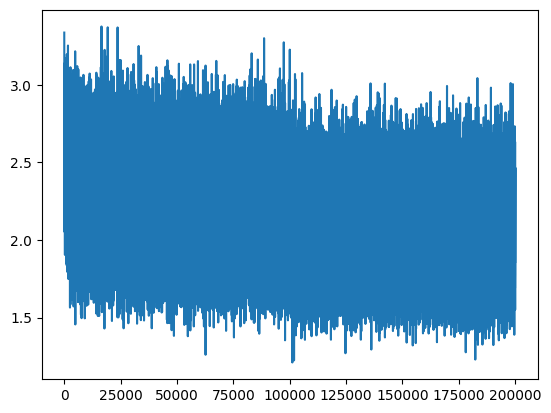

In [8]:
plt.plot(epochs, loss_i)

In [9]:
# Evaluate the loss on validation test
def eval_loss(split):
    if split == "train":
        x_data, y_data = x_train, y_train
    elif split == "test":
        x_data, y_data = x_test, y_test
    elif split == "val":
        x_data, y_data = x_val, y_val
    else:
        raise ValueError("split must be 'train', 'test', or 'val'")

    emb = C[x_data]
    hidden_layer_output = torch.tanh((emb.view(-1, 30) @ weight_1) + bias_1)
    logits = (hidden_layer_output @ weight_2) + bias_2
    loss_val = F.cross_entropy(logits, y_data)
    print(f"Loss on {split} split = {loss_val}")
    return loss_val

val_loss = eval_loss('val')
test_loss = eval_loss('test')
train_loss = eval_loss('train')

Loss on val split = 2.1341588497161865
Loss on test split = 2.1283059120178223
Loss on train split = 2.067924976348877


## Predictions of our Model

In [10]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hidden_layer_output = torch.tanh(emb.view(1, -1) @ weight_1 + bias_1)
        logits = hidden_layer_output @ weight_2 + bias_2
        probs = F.softmax(logits, dim = 1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

yansy.
haviah.
kelle.
khalei.
nya.
tryckendeen.
emberlyn.
jian.
abdeles.
lon.
tou.
ality.
mauz.
lannezalexsenalay.
xaina.
luna.
adari.
zerianne.
neh.
baymontrei.
